# Mapping query data to Fetal Immune reference with scArches

In this notebook, we demonstrate how to use scVI models trained on our fetal immune atlas for query-to-reference mapping of external datasets, making use of the amazing [`scvi-tools`](https://scvi-tools.org/). 

<div class="alert alert-info">

Note: this analysis is much faster with GPU!

</div>

## Getting started

We need a specific version of scvi-tools, otherwise unexpected errors and inconsistencies with `pytorch` might come up.

In [14]:
!pip install scvi-tools==0.14.0 scanpy leidenalg

  Using cached scvi_tools-0.14.0-py3-none-any.whl (231 kB)
  Using cached pytorch_lightning-1.3.8-py3-none-any.whl (813 kB)
  Using cached docrep-0.3.2-py3-none-any.whl
  Using cached pyDeprecate-0.3.0-py3-none-any.whl (10 kB)
  Using cached fsspec-2022.1.0-py3-none-any.whl (133 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.8.7
    Uninstalling fsspec-0.8.7:
      Successfully uninstalled fsspec-0.8.7
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.2.5
    Uninstalling pytorch-lightning-1.2.5:
      Successfully uninstalled pytorch-lightning-1.2.5
  Attempting uninstall: scvi-tools
    Found existing installation: scvi-tools 0.10.0
    Uninstalling scvi-tools-0.10.0:
      Successfully uninstalled scvi-tools-0.10.0


In [83]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import numpy.random as random
import scipy
import anndata
import matplotlib.pyplot as plt

Set up use of GPU

In [2]:
import torch
device = torch.device("cuda")

## Load query dataset
In this tutorial we use as query scRNA-seq data from the fetal gut generated by [Elmentaite et al. 2020](https://www.sciencedirect.com/science/article/pii/S1534580720308868). 

In [3]:
!wget https://cellgeni.cog.sanger.ac.uk/gutcellatlas/fetal_RAWCOUNTS_cellxgene.h5ad

--2022-01-12 16:49:37--  https://cellgeni.cog.sanger.ac.uk/gutcellatlas/fetal_RAWCOUNTS_cellxgene.h5ad
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 193.62.203.62, 193.62.203.63, 193.62.203.61
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|193.62.203.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533655305 (1.4G) [application/x-hdf]
Saving to: ‘fetal_RAWCOUNTS_cellxgene.h5ad’

fetal_RAWCOUNTS_cel 100%[===================>]   1.43G   113MB/s    in 14s     

2022-01-12 16:49:52 (101 MB/s) - ‘fetal_RAWCOUNTS_cellxgene.h5ad’ saved [1533655305/1533655305]



We load the anndata object and subset to the immune cells, to speed up this tutorial. 

In [168]:
query_adata = sc.read_h5ad('./fetal_RAWCOUNTS_cellxgene.h5ad')

In [169]:
query_adata = query_adata[query_adata.obs.cell_type_group == 'immune'].copy()

Before mapping to the fetal immune reference model, we need to check a few things: (A) the model takes in input raw gene counts, so we check that data in `query_adata.X` is not normalized, and (B) the saved models use EnsemblID as variable names, so we need to make sure that `query_adata.var_names` correspond to IDs (rather than gene names).

In [170]:
def _verify_counts(adata):
    return(all([not (i%1) for i in adata.X[0,:].toarray()[0]]))

if not _verify_counts(query_adata):
    raise ValueError('`query_adata.X` does not contain raw counts.')
if not query_adata.var_names.str.startswith("ENS").all():
    raise ValueError('`query_adata.var_names` are not Ensembl geneIDs. Please convert')


ValueError: `query_adata.var_names` are not Ensembl geneIDs. Please convert

In [171]:
## Change var_names to ensemblIDs
query_adata.var['gene_names'] = query_adata.var_names.values.copy()
query_adata.var_names = query_adata.var['gene_ids'].values

## Load trained scVI model

We download the scVI model trained on all immune cells in the fetal immune atlas. Other models trained on lineage subsets (e.g. myeloid cells, NK/T cells) are also available.

In [7]:
!wget https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/scVI_models/scvi_HSC_IMMUNE_model.tar.gz

--2022-01-12 16:50:02--  https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/scVI_models/scvi_HSC_IMMUNE_model.tar.gz
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 193.62.203.63, 193.62.203.61, 193.62.203.62
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|193.62.203.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20084377 (19M) [application/gzip]
Saving to: ‘scvi_HSC_IMMUNE_model.tar.gz’

scvi_HSC_IMMUNE_mod 100%[===================>]  19.15M  --.-KB/s    in 0.1s    

2022-01-12 16:50:03 (165 MB/s) - ‘scvi_HSC_IMMUNE_model.tar.gz’ saved [20084377/20084377]



In [8]:
!tar -xf scvi_HSC_IMMUNE_model.tar.gz

In [9]:
model_dir = './scvi_HSC_IMMUNE_model/'

## Map query data to fetal immune reference

Now we are ready to map the query to the reference.

We first need to define the column in `query_adata.obs` that defines the technical batches from which cells come, and rename it to match the ID used during reference training (`bbk`). For simplicity, here we assume all cells come from the same technical batch.

In [10]:
query_adata.obs["bbk"] = 'fetal_gut'

Next, we need to handle missing genes in the query. These reference models were trained on 7500 highly variable genes in the reference dataset and excluding cell cycle genes and TCR/BCR genes. We need to make sure that the majority of the genes used for training are profiled in the query dataset.

In [11]:
var_names_model = pd.read_csv(model_dir + "var_names.csv", header=None)[0].values
is_in_query_var = pd.Series(var_names_model).isin(query_adata.var_names)
n_genes = len(var_names_model[~is_in_query_var])
print("% or genes missing from query: {p}%".format(p=np.round((n_genes/len(var_names_model))*100,2)))

% or genes missing from query: 1.36%


We replace missing reference genes in the query with zeros, following the workflow proposed by [Lotfollahi et al.](https://www.nature.com/articles/s41587-021-01001-7):

> [...] integration performance was robust when 10% (of 2,000 genes) were missing from query data.

In [12]:
## Zero-filling
empty_X = np.zeros(shape=[ query_adata.n_obs, n_genes])
empty_query_adata = anndata.AnnData(X=empty_X, obs=query_adata.obs)
empty_query_adata.var_names = var_names_model[~is_in_query_var]
empty_query_adata.var_names.names = ["index"]
query_adata_filled = anndata.concat([query_adata, empty_query_adata], axis=1)
query_adata_filled = query_adata_filled[:,var_names_model].copy()
query_adata_filled.obs = query_adata.obs.copy()

Now we are all set to train our model on the query data. We follow the worflow described in the [reference mapping tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html) of `scvi-tools`.

In [13]:
## Load new model with the query data
vae_q = scvi.model.SCVI.load_query_data(
    query_adata_filled,
    model_dir,
    inplace_subset_query_vars=True
)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 1967 cells, 7500 vars, 34 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/opt/conda/envs/ed6/lib/python3.8/site-packages/scvi/model/base/_archesmixin.py:95: UserWarning: Query integration should be performed using models trained with version >= 0.8
  warnings.warn(
/opt/conda/envs/ed6/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [14]:
## Train
vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [00:26<00:00,  7.65it/s, loss=988, v_num=1]     


Now we can extract the latent representation learnt for the query dataset. We save this on the original dataset, which includes all the genes.

In [29]:
query_adata.obsm["X_scvi"] = vae_q.get_latent_representation()

We can use the learnt latent embedding for clustering and visualization of the query dataset. Here we can already see that the scArches mapping allows to separate cells by cell types, rather then Donor identity.

In [30]:
sc.pp.neighbors(query_adata, use_rep="X_scvi")
sc.tl.leiden(query_adata)
sc.tl.umap(query_adata)

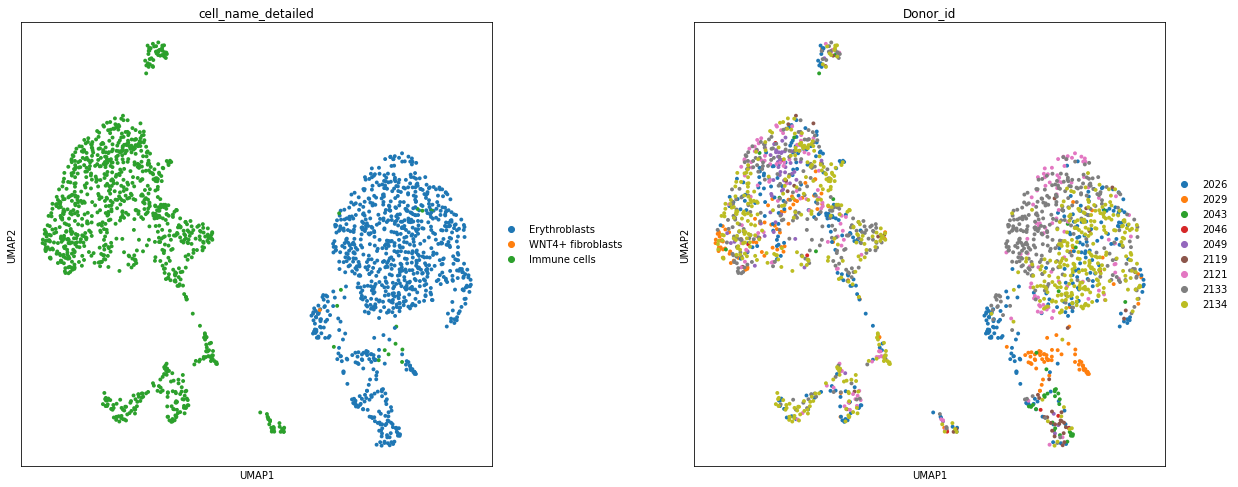

In [176]:
sc.pl.umap(query_adata_filled, color=['cell_name_detailed','Donor_id'], wspace=0.3)

Looking at more marker genes for immune cell populations we can see these distinguish different clusters of query cells.

In [101]:
query_adata.var_names = query_adata.var['gene_names'].values

In [39]:
sc.pp.normalize_per_cell(query_adata)
sc.pp.log1p(query_adata)

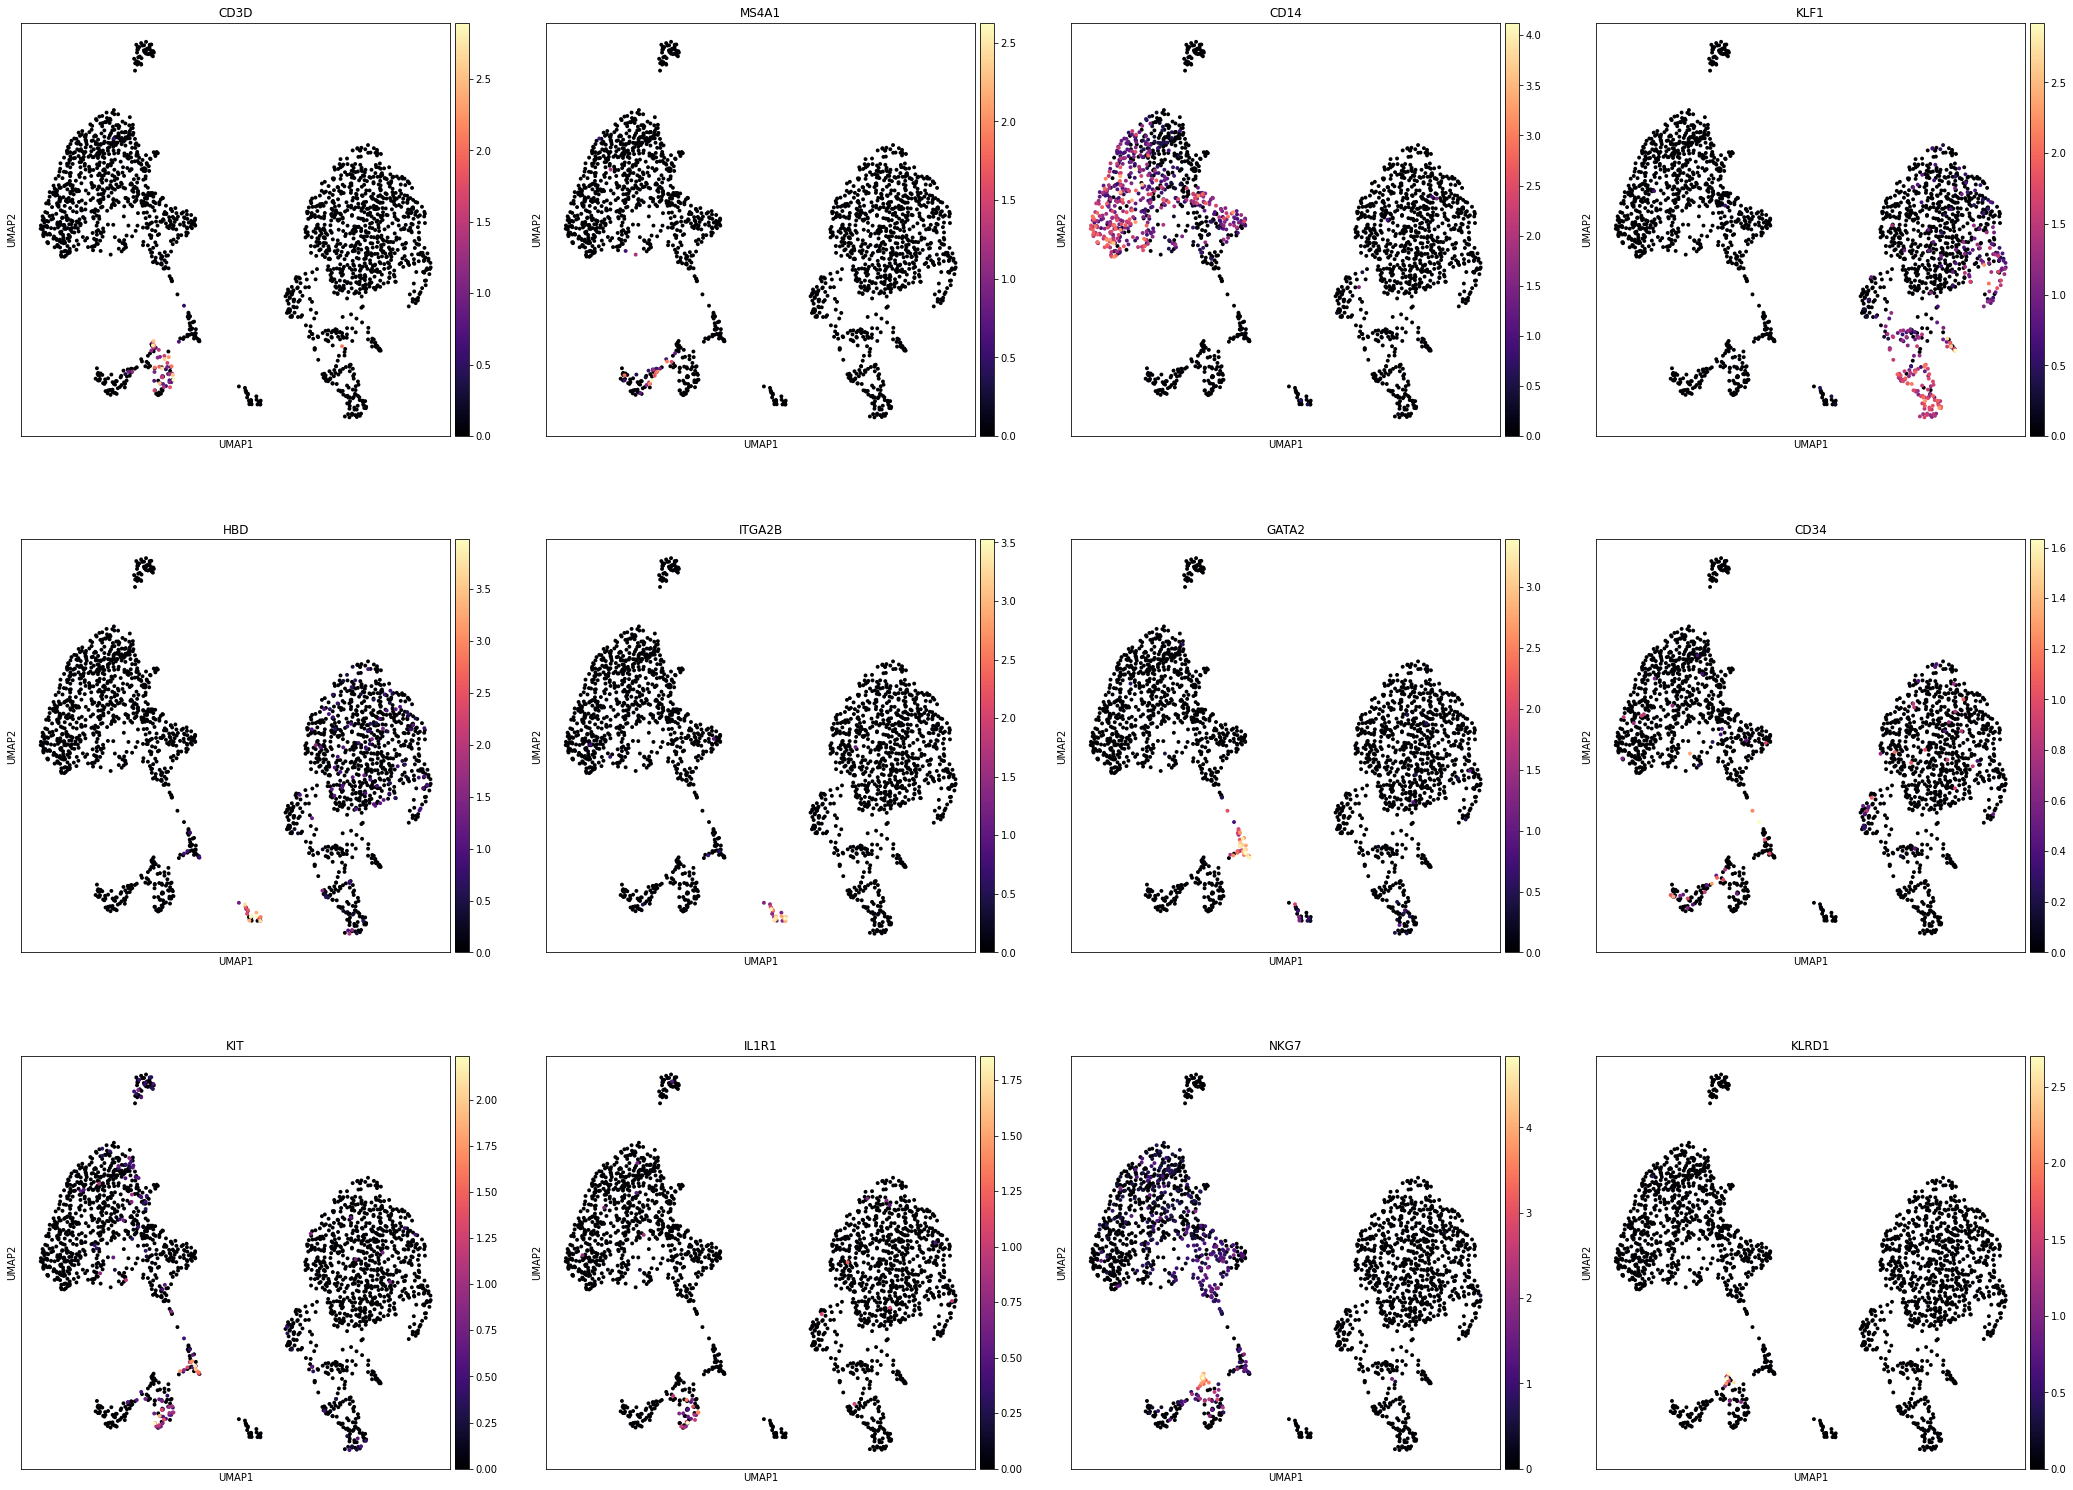

In [161]:
immune_markers = ['CD3D', 
                               'MS4A1', 
                               'CD14',
                               'KLF1', "HBD", "ITGA2B",
                               "GATA2", 'CD34', 
                               'KIT', "IL1R1",
                               'NKG7','KLRD1',
                              ]
sc.pl.umap(query_adata, color=immune_markers, cmap='magma')

## Visualize with fetal immune reference data

We can also jointly analyse the mapped query data with the reference data. To do this we need to download the full dataset (the download might take a few minutes, and loading the object requires a sufficient amount of RAM).

In [55]:
!wget https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad

--2022-01-12 17:03:21--  https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 193.62.203.61, 193.62.203.62, 193.62.203.63
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|193.62.203.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11174824039 (10G) [application/octet-stream]
Saving to: ‘PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad’

PAN.A01.v01.raw_cou 100%[===================>]  10.41G  50.6MB/s    in 4m 9s   

2022-01-12 17:07:30 (42.8 MB/s) - ‘PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad’ saved [11174824039/11174824039]



In [56]:
ref_adata = sc.read_h5ad("./PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad")

In [57]:
ref_adata

AnnData object with n_obs × n_vars = 593203 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

To speed up computations in this tutorial, we subset the reference dataset for joint analysis (e.g. UMAP embedding can take several minutes on a dataset of > 500k cells).

In [75]:
sc.pp.subsample(ref_adata, fraction=0.2)

In [76]:
## Convert var_names to ensembl IDs
ref_adata.var_names = ref_adata.var.GeneID
query_adata.var_names = query_adata.var.gene_ids

In [77]:
## Merge
concat_adata = anndata.concat([ref_adata, query_adata], axis=0,
                              label="dataset", keys=["reference", "query"],
                              join="outer", merge="unique", uns_merge="unique")
concat_adata.obs_names = concat_adata.obs_names + "-" + concat_adata.obs["dataset"].astype("str")


In [78]:
concat_adata

AnnData object with n_obs × n_vars = 120607 × 34241
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'CRL', 'Enrichment_fraction', 'PCW', 'Donor_nb', 'Donor_id', 'Purification', 'Organ', 'doublet_scores_observed_cells', 'percent_mito', 'cell_type_group', 'cell_name', 'cell_name_detailed', 'bbk', 'leiden', 'dataset'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_ids', 'gene_names'
    uns: 'leiden', 'scvi', 'neighbors', 'log1p'
    obsm: 'X_scvi', 'X_umap'

We can now compute a joint KNN graph and UMAP embedding.

In [79]:
## Compute UMAP
sc.pp.neighbors(concat_adata, n_neighbors=30, use_rep="X_scvi")
sc.tl.umap(concat_adata, min_dist = 0.01, spread = 2)

This allows to visualize similarities between query and reference cells

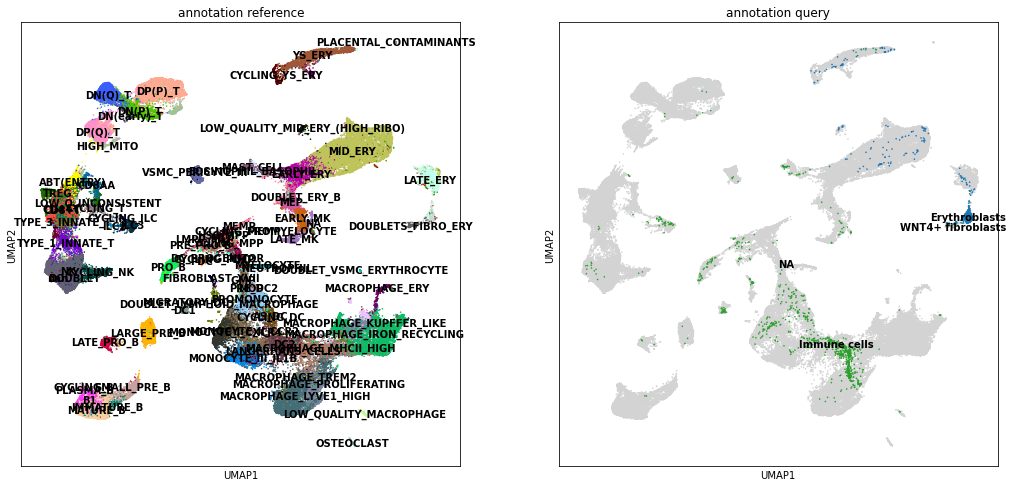

In [153]:
plt.rcParams['figure.figsize'] = [8,8]
sc.pl.umap(concat_adata, color=['celltype_annotation','cell_name_detailed'], size=10, 
           title=['annotation reference', 'annotation query'], legend_loc='on data')

Here we can already distinguish immune cells from different lineages in the query dataset. We can use similarity in the latent embedding to predict cell identity of these cells. We implement a utility function to do this in `Pan_fetal_immune/src/utils/scArches_utils/map_query_utils.py`. This stores predicted annotations in `adata.obs['predicted_anno']`.

In [107]:
import sys
sys.path.append('../src/utils/scArches_utils/')
import map_query_utils

In [154]:
map_query_utils.predict_label2(concat_adata, anno_col='celltype_annotation', min_score=0.5)

0.3734002113342285


In [155]:
n_cells = concat_adata.obs['predicted_anno'].value_counts()
n_cells

LATE_ERY                           659
MACROPHAGE_MHCII_HIGH              242
low_confidence                     189
MACROPHAGE_LYVE1_HIGH              132
DOUBLETS_FIBRO_ERY                 118
DC2                                 87
MID_ERY                             74
YS_ERY                              52
MACROPHAGE_PROLIFERATING            46
DC1                                 40
MONOCYTE_I_CXCR4                    37
PRO_B                               30
PROMONOCYTE                         29
MONOCYTE_II_CCR2                    29
ILC3                                21
MAST_CELL                           19
CYCLING_DC                          18
PRE_PRO_B                           12
NK                                  12
CYCLING_YS_ERY                       9
EARLY_MK                             9
PDC                                  9
EOSINOPHIL_BASOPHIL                  9
LOW_QUALITY_MID_ERY_(HIGH_RIBO)      8
MONOCYTE_III_IL1B                    8
CYCLING_ILC              

/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_anno' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_anno_unfiltered' as categorical


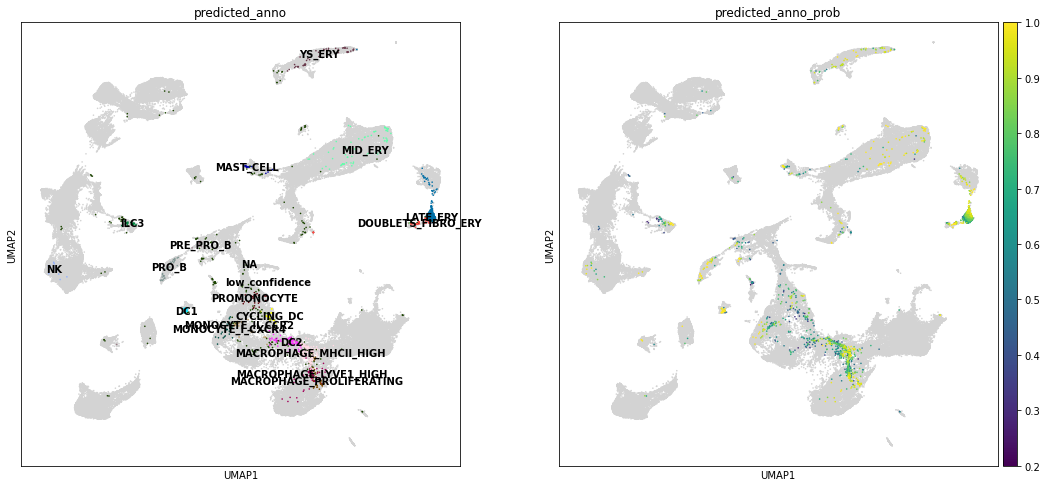

In [156]:
## Exclude low abundance predictions
low_ab_predictions = n_cells.index[n_cells < 10]
concat_adata.obs.loc[concat_adata.obs['predicted_anno'].isin(low_ab_predictions), 'predicted_anno'] = 'low_confidence'
sc.pl.umap(concat_adata, color=['predicted_anno','predicted_anno_prob'], size=10, legend_loc='on data')

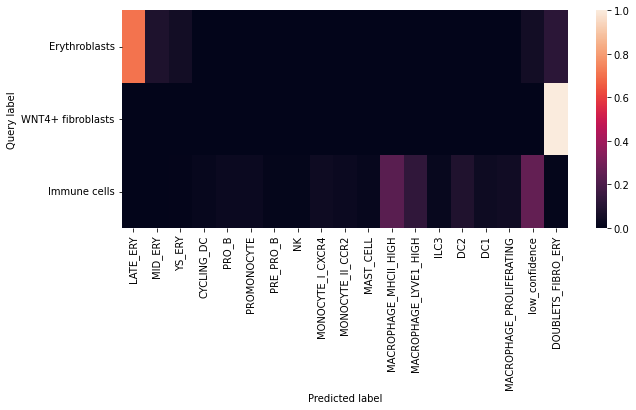

In [157]:
plt.rcParams['figure.figsize'] = [10,4]
map_query_utils.plot_confusion_mat(concat_adata, query_anno_col='cell_name_detailed')

Visualize predicted labels on query data only and compare with expression of immune cell markers.

In [158]:
query_adata.obs['predicted_anno'] = concat_adata.obs[concat_adata.obs['dataset']=='query']['predicted_anno'].values

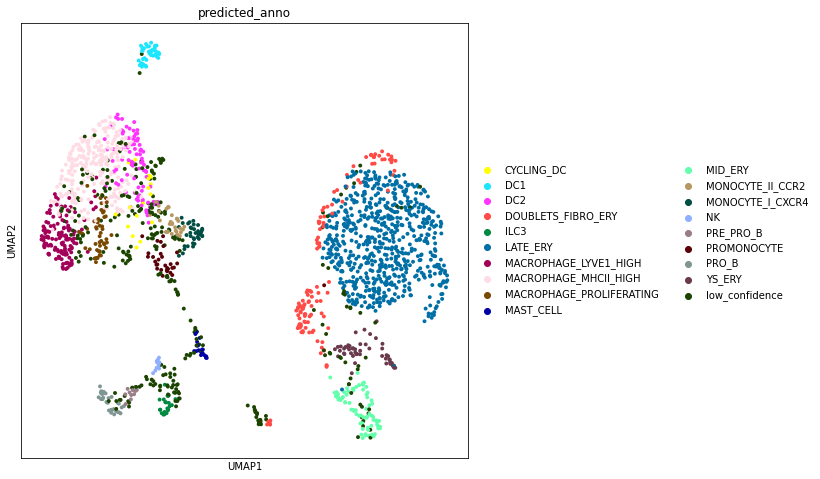

In [160]:
plt.rcParams['figure.figsize'] = [8,8]
sc.pl.umap(query_adata, color=['predicted_anno'])

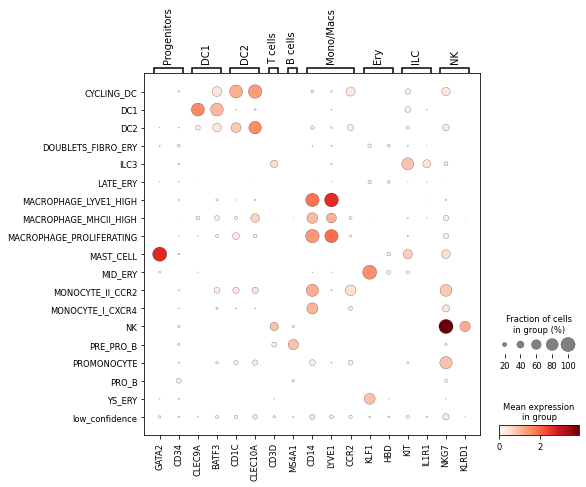

In [167]:
immune_markers = {
    "Progenitors":["GATA2", 'CD34'],
    'DC1':["CLEC9A", "BATF3"],
    "DC2":["CD1C", "CLEC10A"],
    "T cells":['CD3D'], 
    'B cells':['MS4A1'], 
    "Mono/Macs":['CD14', "LYVE1", "CCR2"],
    'Ery':['KLF1', "HBD"],
    'ILC':['KIT', "IL1R1"],
    'NK':['NKG7','KLRD1']
                 }

sc.pl.dotplot(query_adata,immune_markers, groupby='predicted_anno')

---